# 06 Changing a model

The first thing you might have noticed about the previous notebook is that we didn't define the model. Behind the scenes a basic model was created and encapsulated inside a simulation and this was run by the solver. The reason for this is currently the distributed solvers handle functions that create objects inside processes better than being passed objects directly. This adds a little complication to the solving process but hopefully not that much. This notebook demonstrates how to change the model by passing a `sim_func`.

In [1]:
try:
    import liionpack as lp
except:
    !pip install -q git+https://github.com/pybamm-team/liionpack.git@main
    import liionpack as lp
import pybamm
import numpy as np

Liionpack includes a couple of pre-defined `sim_func` functions for you so let's check them out first

The idea is that the function gets called behind the scenes by the solvers and we pass in the parameter_values dictionary and return a simulation that is ready to build and use.

In [2]:
import inspect

lines = inspect.getsource(lp.basic_simulation)
print(lines)

def basic_simulation(parameter_values=None):
    """
    Create a Basic PyBaMM simulation set up for integration with liionpack

    Args:
        parameter_values (pybamm.ParameterValues):
            The default is None.

    Returns:
        pybamm.Simulation:
            A simulation that can be solved individually or passed into the
            liionpack solve method

    """
    # Create the pybamm model
    model = pybamm.lithium_ion.SPM()

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        param = pybamm.ParameterValues("Chen2020")
    else:
        param = parameter_values.copy()

    # Set up solver and simulation
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(
        model=model,
        parameter_values=param,
        solver=solver,
    )
    return sim



The basic ingredients for a simulation in PyBaMM are the model, parameter_values and solver. We can optionally add events to the liionpack simulation by explicitly adding them as variables using the helper function `add_events_to_model`. We also need to use the casadi solver and different modes have not been currently not been tested but "safe" mode is known to work.

Let's run the function to get a simulation and solve it outside of the normal liionpack solving process to get an idea of the output of the model for a single cell

In [3]:
sim = lp.basic_simulation()
sim.solve([0, 3600])
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3567.8531790808343, step=35.67853179080834),…

Another pre-defined `sim_func` is the `thermal_simulation`

In [4]:
lines = inspect.getsource(lp.thermal_simulation)
print(lines)

def thermal_simulation(parameter_values=None):
    """
    Create a PyBaMM simulation set up for integration with liionpack

    Args:
        parameter_values (pybamm.ParameterValues):
            The default is None.

    Returns:
        pybamm.Simulation:
            A simulation that can be solved individually or passed into the
            liionpack solve method

    """
    # Create the pybamm model
    model = pybamm.lithium_ion.SPMe(
        options={
            "thermal": "lumped",
        }
    )

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        parameter_values = pybamm.ParameterValues("Chen2020")

    # Change the heat transfer coefficient to be an input controlled by the
    # external circuit
    parameter_values.update(
        {
            "Total heat transfer coefficient [W.m-2.K-1]": "[input]",
        },
    )

    # Set up solver and simulation
    solver = pybamm.Casad

The thermal model does not have to be run with heat transfer coefficients as inputs but this is the easiest way to alter cooling conditions within the pack.

In [5]:
tSim = lp.thermal_simulation()
htcs = [5.0, 10.0, 20.0]
sols = []
for htc in htcs:
    sols.append(
        tSim.solve(
            [0, 3600], inputs={"Total heat transfer coefficient [W.m-2.K-1]": htc}
        )
    )

In [6]:
pybamm.QuickPlot(
    solutions=sols,
    output_variables=["Terminal voltage [V]", "Volume-averaged cell temperature [K]"],
    labels=htcs,
).dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3566.933290300665, step=35.66933290300665), …

To use the bespoke functions in liionpack let's first create a netlist and then solve it.

In [7]:
netlist = lp.setup_circuit(Np=10, Ns=1, Rb=1e-3, Rc=1e-2, Ri=1e-2, V=3.6, I=20)
parameter_values = pybamm.ParameterValues("Chen2020")
experiment = pybamm.Experiment(
    operating_conditions=["Discharge at 20 A for 1 hour"], period="1 minute"
)

In [8]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=lp.thermal_simulation,
    output_variables=["Volume-averaged cell temperature [K]"],
    inputs={"Total heat transfer coefficient [W.m-2.K-1]": np.ones(10) * 10.0},
)

Stepping simulation: 100%|█████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 26.63it/s]


The input array must be the same length as the number of cells in the pack. Here we have solved for every battery having the same heat transfer coefficient and thermal differences arise from the different cell currents

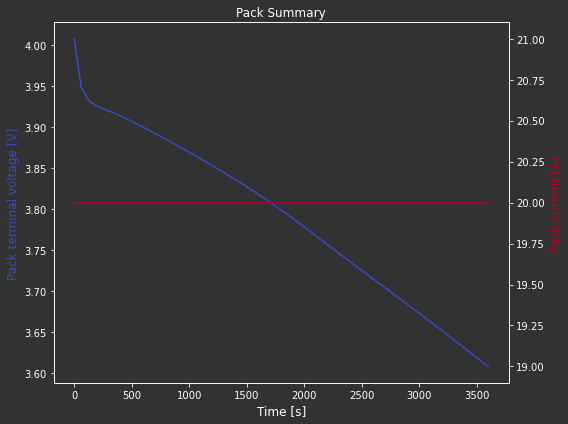

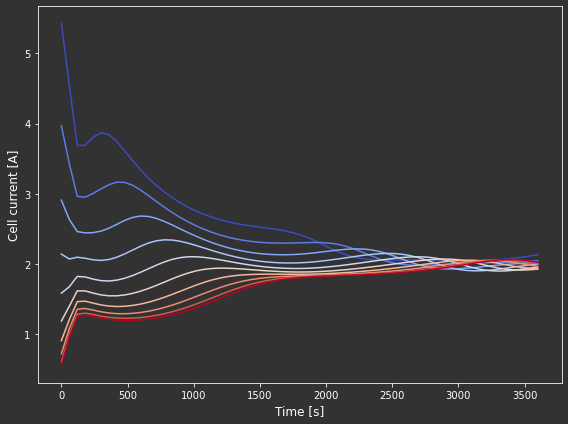

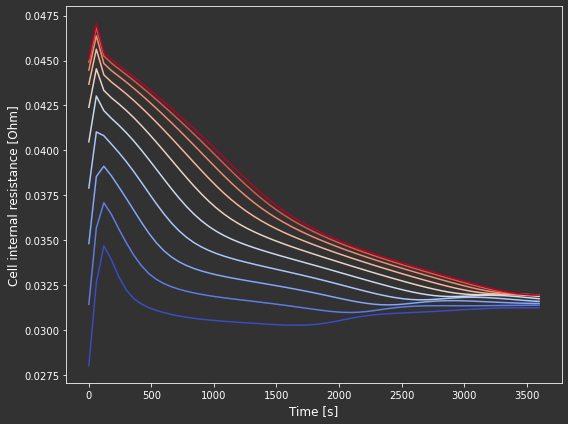

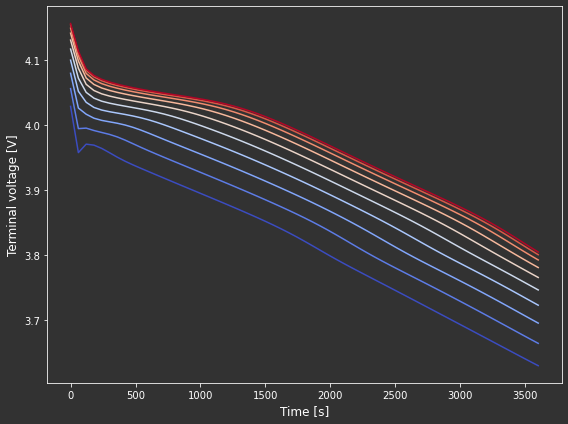

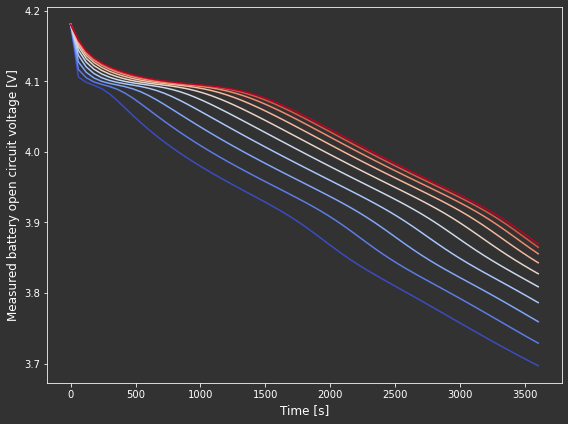

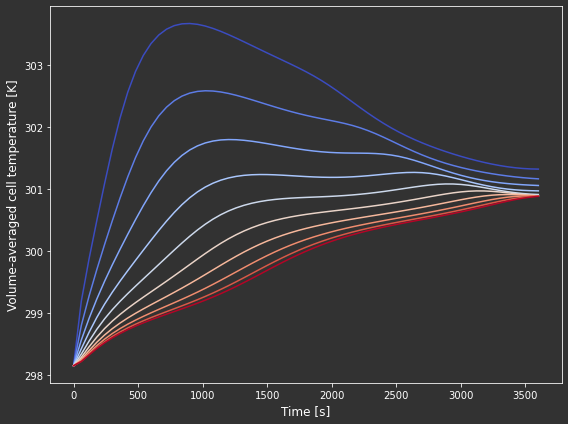

In [9]:
lp.plot_output(output)

In [10]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=lp.thermal_simulation,
    output_variables=["Volume-averaged cell temperature [K]"],
    inputs={
        "Total heat transfer coefficient [W.m-2.K-1]": np.linspace(1, 10, 10) * 10.0
    },
)

Stepping simulation: 100%|█████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 26.74it/s]


We can easily prescribe a different heat transfer coefficient for each cell and see the results

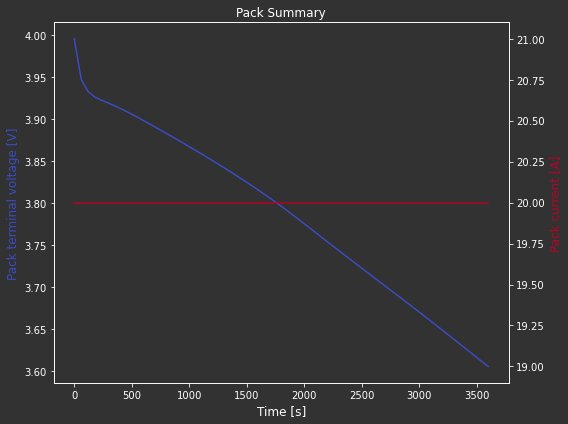

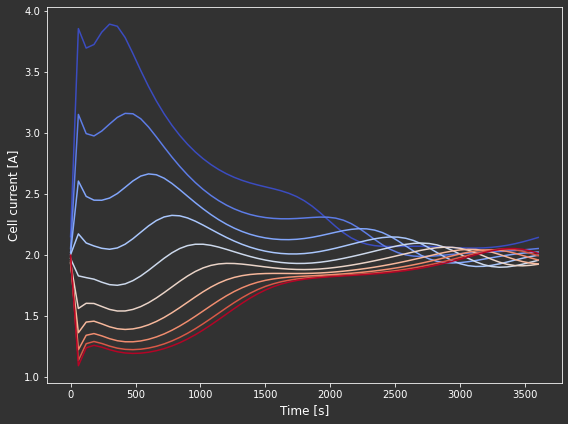

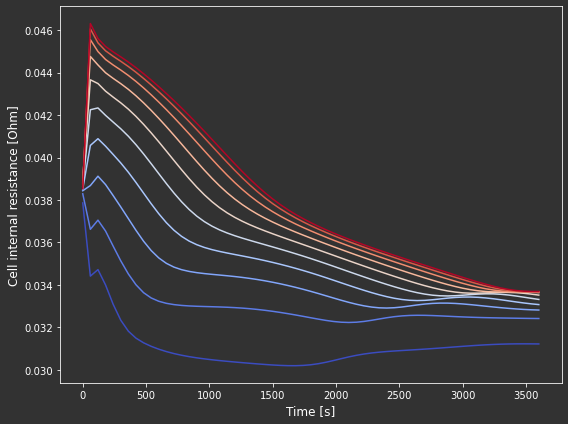

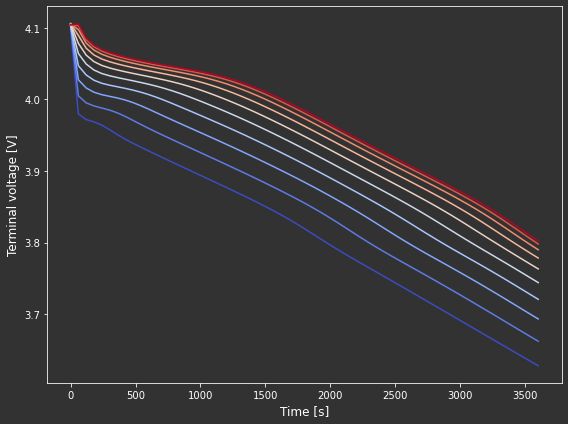

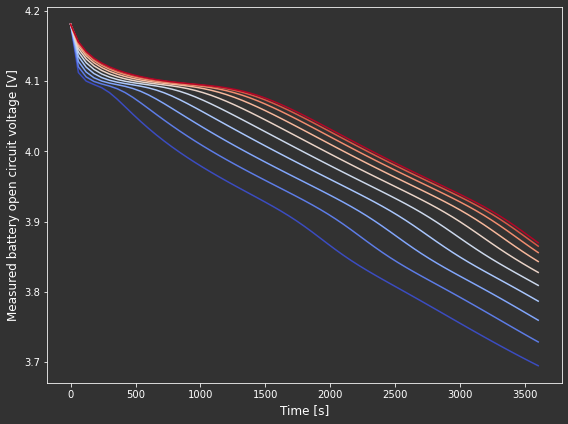

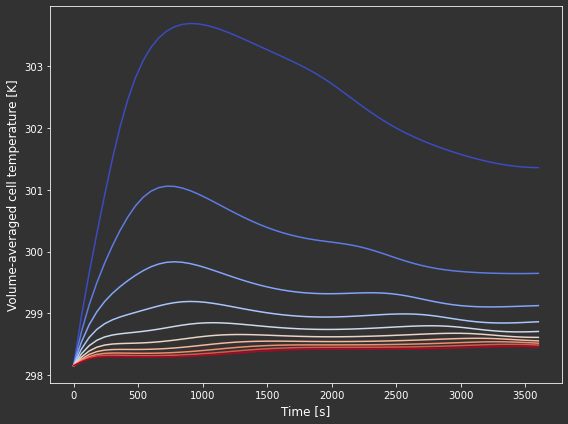

In [11]:
lp.plot_output(output)